## Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Standard imports
import glob

# 3rd party imports
import cv2
import matplotlib.pyplot as plt
import numpy as np 
from pprint import pprint
import SimpleITK as sitk

## Functions

In [2]:
def read_tif(filepath):
    """
    Read tiff files using SimpleITK
    
    Args:
        filepath: str, path to tiff file
        
    Returns:
        image: np.ndarray, tiff image
    """
    image = sitk.ReadImage(filepath)
    image = sitk.GetArrayFromImage(image)
    return image


def auto_contrast(data: np.ndarray, alpha: float = None, beta: float = None) -> np.ndarray:
    """
    Preprocess tiff files to automatically adjust brightness and contrast.
    https://stackoverflow.com/questions/56905592/automatic-contrast-and-brightness-adjustment-of-a-color-photo-of-a-sheet-of-pape
    """
    if not alpha:
        alpha = np.iinfo(data.dtype).max / (np.max(data) - np.min(data))
    if not beta:
        beta = -np.min(data) * alpha
    img = cv2.convertScaleAbs(data.copy(), alpha=alpha, beta=beta)
    return img


def gamma_correction(image: np.ndarray, gamma: float=2.0) -> np.ndarray:
    """
    Apply gamma correction to the image.
    
    Args:
        image: np.ndarray, input image
        gamma: float, gamma value
        
    Returns:
        image_enhanced: np.ndarray, gamma corrected image
    """
    # Normalize the image to the range [0, 1]
    image_normalized = image / image.max()
    # Apply the exponential transformation
    image_enhanced = np.power(image_normalized, gamma)
    # Rescale the image back to the original intensity range
    image_enhanced = image_enhanced * image.max()
    return image_enhanced


def compute_average_image(images):
    """
    Compute the average image from a list of images.
    
    Args:
        images: list, list of images
        
    Returns:
        average_image: np.ndarray, average image
    """
    average_image = np.mean(images, axis=0)
    return average_image


def show_4(original_image, contrast_enhanced, thresholded, xlim=None, ylim=None):
    plt.figure(figsize=(20, 20))
    plt.subplot(2, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original zoomed")
    if xlim is not None:
        plt.xlim(xlim)
        plt.ylim(ylim[::-1])

    plt.subplot(2, 2, 2)
    plt.imshow(contrast_enhanced, cmap='gray')
    plt.title("Contrast enhanced")
    if xlim is not None:
        plt.xlim(xlim)
        plt.ylim(ylim[::-1])

    plt.subplot(2, 2, 3)
    plt.imshow(thresholded, cmap='gray')
    plt.title("Thresholded")
    if xlim is not None:
        plt.xlim(xlim)
        plt.ylim(ylim[::-1])

    plt.subplot(2, 2, 4)
    plt.imshow(contrast_enhanced, cmap='gray')
    plt.contour(thresholded, colors='red', linewidths=0.5, alpha=0.35)
    plt.title("Contrast enhanced + contour")
    if xlim is not None:
        plt.xlim(xlim)
        plt.ylim(ylim[::-1])
    plt.show()
    
    
def save_figure(image, filename, contours=None):
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap='gray')
    if contours is not None:
        plt.contour(contours, colors='red', linewidths=0.15, alpha=0.35)
    plt.axis('off')
    plt.savefig(filename, dpi=600, bbox_inches='tight')
    print(f"Saved figure to {filename}")

In [3]:
import itk
import numpy as np
from skimage.morphology import remove_small_objects, binary_closing, disk, remove_small_holes


def detect_vessels(input_image: np.ndarray, min_sigma: float=1.0, max_sigma: float=10.0, num_steps: int=10):
    # Run ITK
    input_image = itk.image_from_array(input_image)
    #input_image = itk.imread(input_image, itk.F)

    ImageType = type(input_image)
    Dimension = input_image.GetImageDimension()
    HessianPixelType = itk.SymmetricSecondRankTensor[itk.D, Dimension]
    HessianImageType = itk.Image[HessianPixelType, Dimension]

    objectness_filter = itk.HessianToObjectnessMeasureImageFilter[
        HessianImageType, ImageType
    ].New()
    objectness_filter.SetBrightObject(False)  # Set to True if the structures are bright on a dark background
    objectness_filter.SetScaleObjectnessMeasure(False)  # Set to True to scale the objectness measure by the scale
    objectness_filter.SetAlpha(0.5)  # Sensitivity to blob-like structures
                                     # Set/Get Alpha, the weight corresponding to R_A 
                                     # (the ratio of the smallest eigenvalue that has to be large to the larger ones). 
                                     # Smaller values lead to increased sensitivity to the object dimensionality.
    objectness_filter.SetBeta(0.5)   # Sensitivity to plate-like structures
                                     # Set/Get Beta, the weight corresponding to R_B 
                                     # (the ratio of the largest eigenvalue that has to be small to the larger ones). 
                                     # Smaller values lead to increased sensitivity to the object dimensionality.
    objectness_filter.SetGamma(5.0)  # Sensitivity to noise
                                     # Set/Get Gamma, the weight corresponding to S 
                                     # (the Frobenius norm of the Hessian matrix, or second-order structureness)

    multi_scale_filter = itk.MultiScaleHessianBasedMeasureImageFilter[
        ImageType, HessianImageType, ImageType
    ].New()
    multi_scale_filter.SetInput(input_image)
    multi_scale_filter.SetHessianToMeasureFilter(objectness_filter)
    multi_scale_filter.SetSigmaStepMethodToLogarithmic()
    multi_scale_filter.SetSigmaMinimum(min_sigma)
    multi_scale_filter.SetSigmaMaximum(max_sigma)
    multi_scale_filter.SetNumberOfSigmaSteps(num_steps)

    OutputPixelType = itk.UC
    OutputImageType = itk.Image[OutputPixelType, Dimension]

    rescale_filter = itk.RescaleIntensityImageFilter[ImageType, OutputImageType].New()
    rescale_filter.SetInput(multi_scale_filter)
    rescale_filter.Update()

    # Get numpy array
    segmented_vessels = rescale_filter.GetOutput()
    segmented_vessels_array = itk.array_view_from_image(segmented_vessels)
    segmented_vessels_array = np.asarray(segmented_vessels_array, dtype=np.float32)
    return segmented_vessels_array


def process_vessels(vessel_image: np.ndarray, thresh: int, min_size: int=10, area_threshold: float=2000, smoothing: int=3):
    # Process the thresholded vessels
    thresholded_vessels = vessel_image > thresh
    thresholded_vessels = np.invert(thresholded_vessels)

    # Get rid of small objects
    thresholded_vessels = remove_small_objects(thresholded_vessels, min_size=min_size)
    thresholded_vessels = remove_small_holes(thresholded_vessels, area_threshold=area_threshold)

    # Smoothen edges
    thresholded_vessels = binary_closing(thresholded_vessels, footprint=disk(smoothing))
    
    return thresholded_vessels


def get_brain_mask(brain_image, area_threshold=300000, min_size=10000):
    """
    Get the mask of the brain from the image (run before contrast enhancement).
    
    Args:
        brain_image: np.ndarray, input image
        thresh: int, threshold value
        area_threshold: int, area threshold
        
    Returns:
        mask: np.ndarray, mask of the brain
    """
    _, mask = cv2.threshold(brain_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)
    mask = remove_small_holes(mask.astype(bool), area_threshold=area_threshold)
    mask = remove_small_objects(mask, min_size=min_size)
    #assert( labels.max() != 0 ) # assume at least 1 CC
    #largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return mask


## Load data

In [4]:
m1_path = "/media/data/u01/Endothelial_enhancer/Fig3_M14_*.tif"
m1_data = sorted(glob.glob(m1_path))
m1_data

['/media/data/u01/Endothelial_enhancer/Fig3_M14_slice 1.tif',
 '/media/data/u01/Endothelial_enhancer/Fig3_M14_slice 2.tif',
 '/media/data/u01/Endothelial_enhancer/Fig3_M14_slice 3.tif',
 '/media/data/u01/Endothelial_enhancer/Fig3_M14_slice 4.tif',
 '/media/data/u01/Endothelial_enhancer/Fig3_M14_slice 5.tif']

Apply exponential scaling on the image

TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


Image shape: (3, 9166, 11914)
Image shape: (9166, 11914)
Image min: 0
Image max: 65535
Image mean: 6245.114320881585


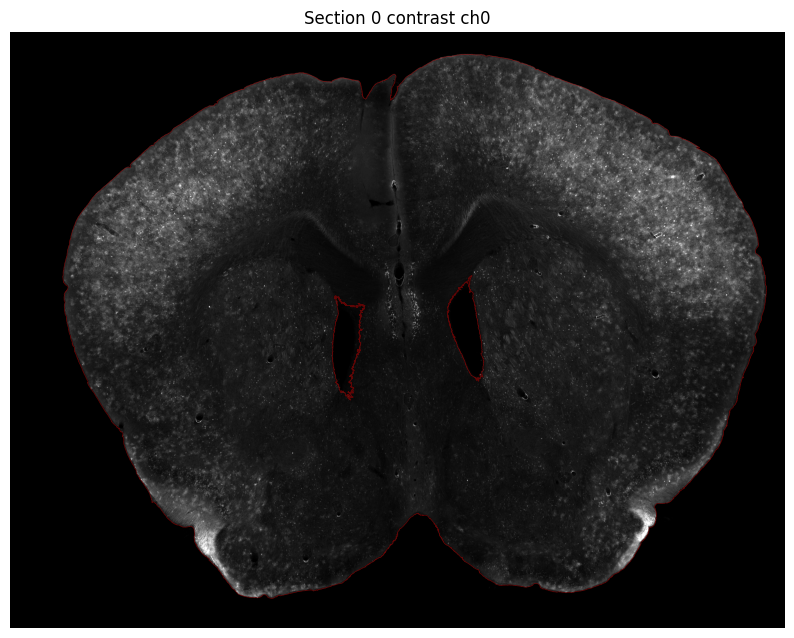

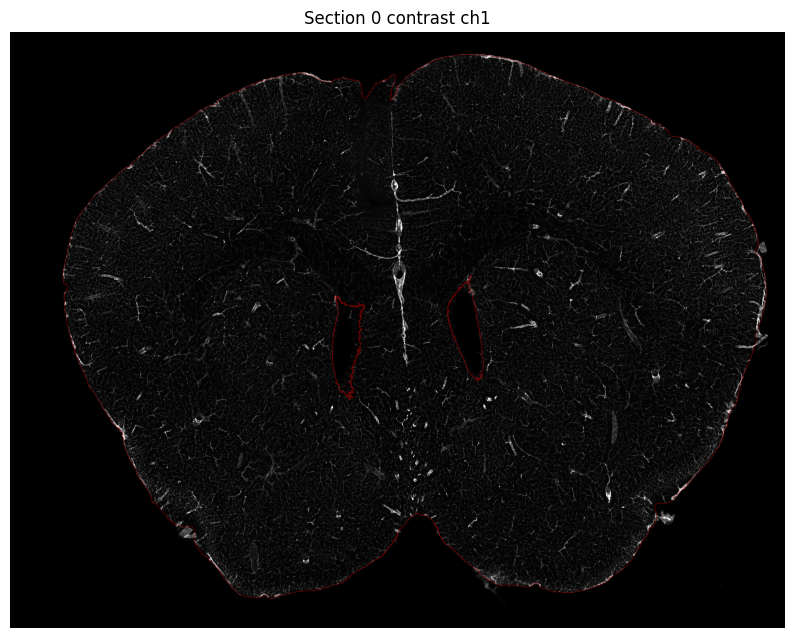

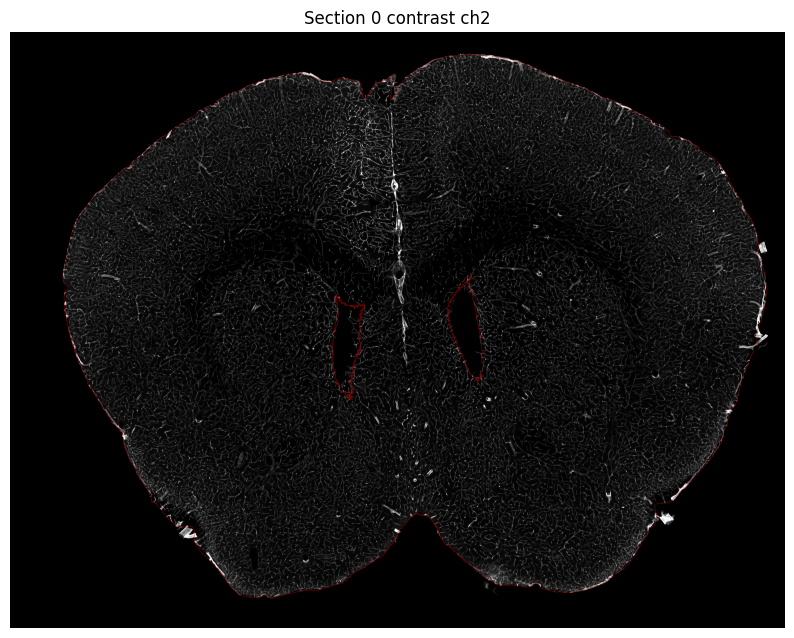

In [13]:
IDX = 0
curr_img = read_tif(m1_data[IDX])
print(f"Image shape: {curr_img.shape}")
curr_ch0 = curr_img[0]
curr_ch1 = curr_img[1]
curr_ch2 = curr_img[2]

# Check image stats
print(f"Image shape: {curr_ch0.shape}")
print(f"Image min: {curr_ch0.min()}")
print(f"Image max: {curr_ch0.max()}")
print(f"Image mean: {curr_ch0.mean()}")


# Ch0 settings
gamma_ch0 = 2  # You can adjust this value to control the contrast enhancement
contrast_alpha_ch0 = 0.5  # Try 0.15 You can adjust this value to control the brightness enhancement 0.5 default

# Ch1 settings
gamma_ch1 = 2  # You can adjust this value to control the contrast enhancement
contrast_alpha_ch1 = 1.5  # Try 0.15 You can adjust this value to control the brightness enhancement 0.5 default

# No change
contrast_ch0 = curr_ch0
contrast_ch1 = curr_ch1
contrast_ch2 = curr_ch2

# Compute the original image contrast
#contrast_ch0 = gamma_correction(curr_ch0, gamma=gamma_ch0)
#contrast_ch0 = auto_contrast(contrast_ch0, alpha=contrast_alpha_ch0)
#contrast_ch1 = gamma_correction(curr_ch1, gamma=gamma_ch1)
#contrast_ch1 = auto_contrast(contrast_ch1, alpha=contrast_alpha_ch1)

bg_mask = gamma_correction(curr_ch0, gamma=gamma_ch0)
bg_mask = auto_contrast(bg_mask, alpha=3.0)
bg_mask = get_brain_mask(bg_mask, area_threshold=100000)  # 255 default ch0, 150 for ch1

plt.figure(figsize=(10, 10))
plt.imshow(contrast_ch0, cmap='gray')
plt.contour(bg_mask, colors='red', linewidths=0.5, alpha=0.35)
plt.title(f"Section {IDX} contrast ch0")
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(contrast_ch1, cmap='gray')
plt.contour(bg_mask, colors='red', linewidths=0.5, alpha=0.35)
plt.title(f"Section {IDX} contrast ch1")
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(contrast_ch2, cmap='gray')
plt.contour(bg_mask, colors='red', linewidths=0.5, alpha=0.35)
plt.title(f"Section {IDX} contrast ch2")
plt.axis('off')
plt.show()

## Hessian Filter
https://examples.itk.org/src/nonunit/review/segmentbloodvesselswithmultiscalehessianbasedmeasure/documentation

Input image type: float32
Input image min: 0.0
Input image max: 65535.0
Vesselness image statistics:
Shape: (9166, 11914)
Min: 0.0
Max: 255.0
Mean: 134.35667
Median: 217.0


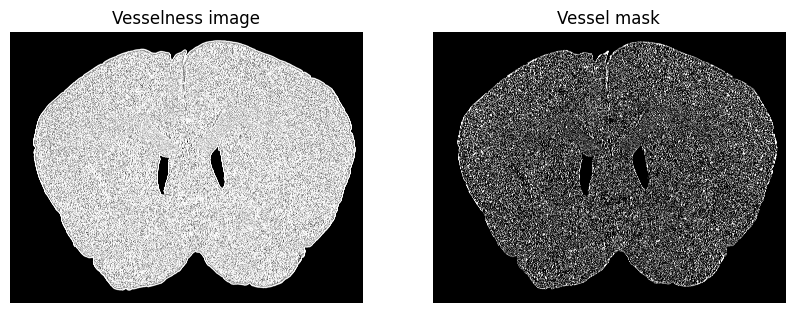

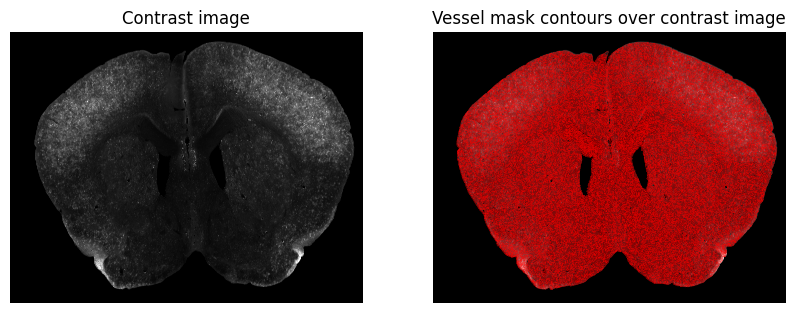

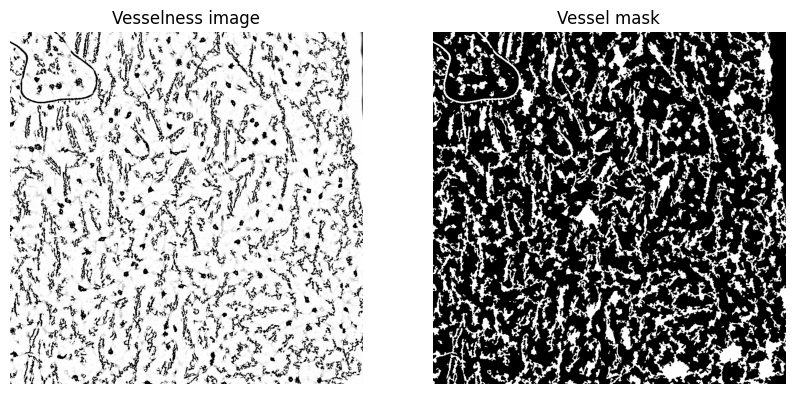

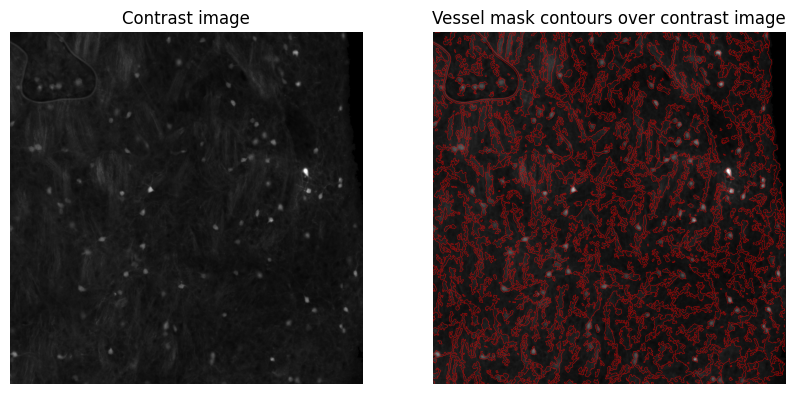

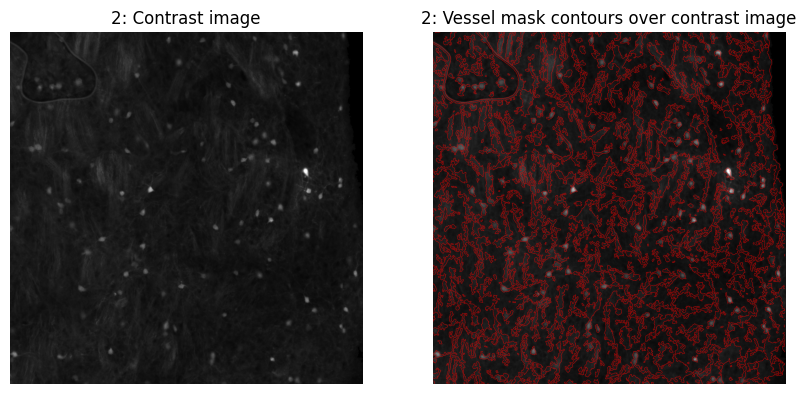

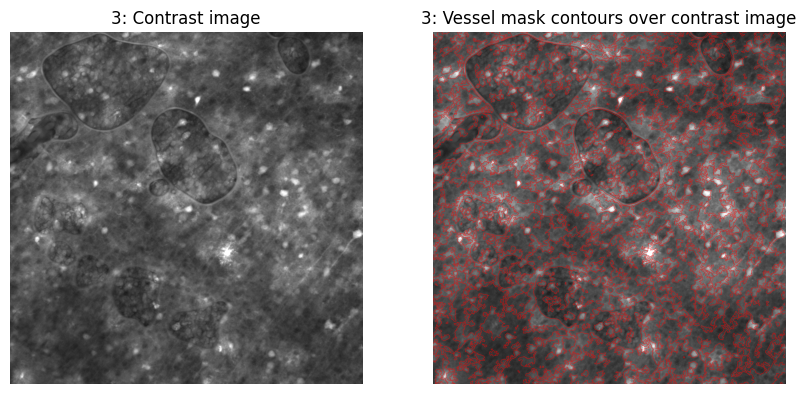

In [14]:
# Parameters for vessel detection
sigma_minimum = 1.0  # Range of scales in which MultiScaleHessianBasedMeasureImageFilter will search for vessels
sigma_maximum = 10.0  # 10
number_of_sigma_steps = 10  # 10 Number of scales to search for vessels

# Parameters for post-processing
thresh = 230  # Threshold for binarization, 230
min_size = 10  # Minimum size of objects to keep
area_threshold = 2000 # Minimum area of holes to keep
smoothing = 1  # Smoothing factor for closing, 3

xlim = [4000, 5000]  # 8000, 9000 or 9000, 10000
ylim = [4000, 5000]  # 8000, 9000

#############################################################

# Alternative: load image in memory
input_image = contrast_ch0 * bg_mask
input_image = input_image.astype(np.float32)
#input_image *= 255.0

# Print statistics
print("Input image type:", input_image.dtype)
print("Input image min:", input_image.min())
print("Input image max:", input_image.max())

# Run the vessel detection
segmented_vessels_array = detect_vessels(input_image, sigma_minimum, sigma_maximum, number_of_sigma_steps)

# Process the thresholded vessels
thresholded_vessels_ch0 = process_vessels(segmented_vessels_array, thresh=thresh, min_size=min_size, area_threshold=area_threshold, smoothing=smoothing)
thresholded_vessels_ch0 = thresholded_vessels_ch0 * bg_mask

# Print statistics
print("Vesselness image statistics:")
print("Shape:", segmented_vessels_array.shape)
print("Min:", segmented_vessels_array.min())
print("Max:", segmented_vessels_array.max())
print("Mean:", segmented_vessels_array.mean())
print("Median:", np.median(segmented_vessels_array))
#print("Std:", segmented_vessels_array.std())

# Plot the raw vesselness image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(segmented_vessels_array, cmap='gray')
plt.axis('off')
plt.title("Vesselness image")
plt.subplot(1, 2, 2)
plt.imshow(thresholded_vessels_ch0, cmap='gray')
plt.axis('off')
plt.title("Vessel mask")
plt.show()

# Show the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.axis('off')
plt.title("Contrast image")
plt.subplot(1, 2, 2)
plt.imshow(input_image, cmap='gray')
plt.contour(thresholded_vessels_ch0, colors='red', linewidths=0.5, alpha=0.45)
plt.axis('off')
plt.title("Vessel mask contours over contrast image")
plt.show()

# Plot the raw vesselness image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(segmented_vessels_array, cmap='gray')
plt.axis('off')
plt.title("Vesselness image")
plt.xlim(xlim)
plt.ylim(ylim)
plt.subplot(1, 2, 2)
plt.imshow(thresholded_vessels_ch0, cmap='gray')
plt.axis('off')
plt.title("Vessel mask")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# Show the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.axis('off')
plt.title("Contrast image")
plt.xlim(xlim)
plt.ylim(ylim)
plt.subplot(1, 2, 2)
plt.imshow(input_image, cmap='gray')
plt.contour(thresholded_vessels_ch0, colors='red', linewidths=0.5, alpha=0.45)
plt.axis('off')
plt.title("Vessel mask contours over contrast image")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# Show the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.axis('off')
plt.title("2: Contrast image")
plt.xlim(ylim)
plt.ylim(ylim)
plt.subplot(1, 2, 2)
plt.imshow(input_image, cmap='gray')
plt.contour(thresholded_vessels_ch0, colors='red', linewidths=0.5, alpha=0.45)
plt.axis('off')
plt.title("2: Vessel mask contours over contrast image")
plt.xlim(ylim)
plt.ylim(ylim)
plt.show()

# Show the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.axis('off')
plt.title("3: Contrast image")
plt.xlim([2000, 3000])
plt.ylim([2000, 3000])
plt.subplot(1, 2, 2)
plt.imshow(input_image, cmap='gray')
plt.contour(thresholded_vessels_ch0, colors='red', linewidths=0.5, alpha=0.45)
plt.axis('off')
plt.title("3: Vessel mask contours over contrast image")
plt.xlim([2000, 3000])
plt.ylim([2000, 3000])
plt.show()

Repeat for ch1

Input image type: float32
Input image min: 0.0
Input image max: 65535.0
Vesselness image statistics:
Shape: (9166, 11914)
Min: 0.0
Max: 255.0
Mean: 138.49945
Median: 238.0


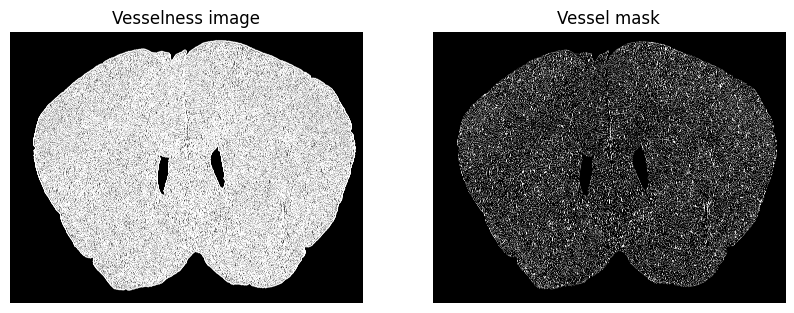

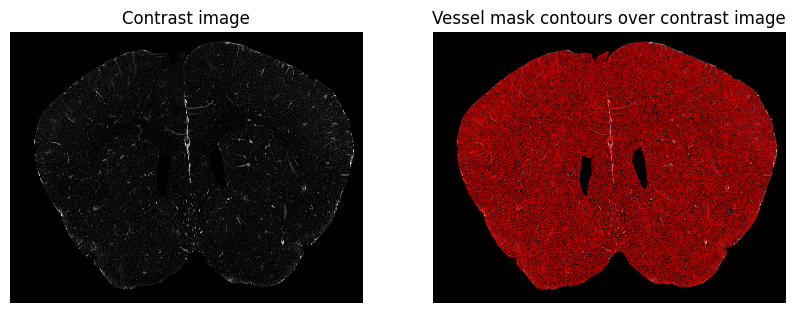

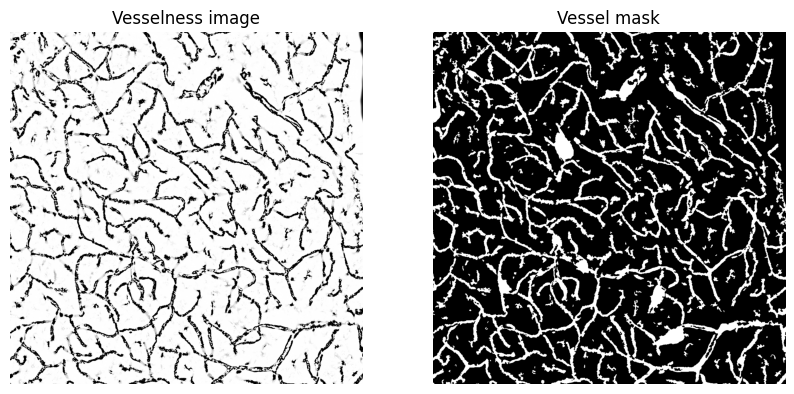

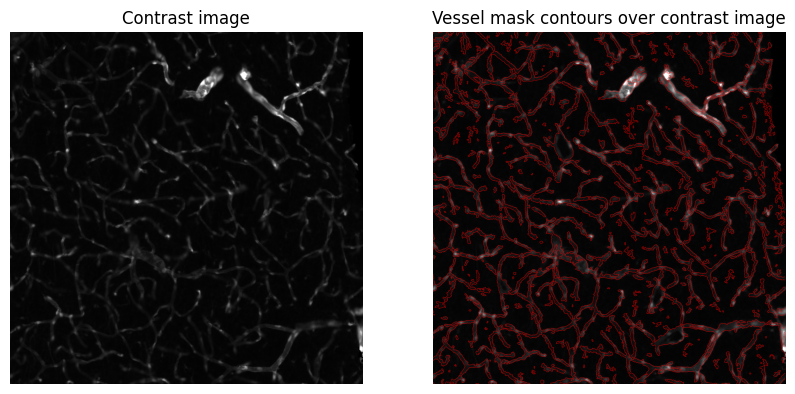

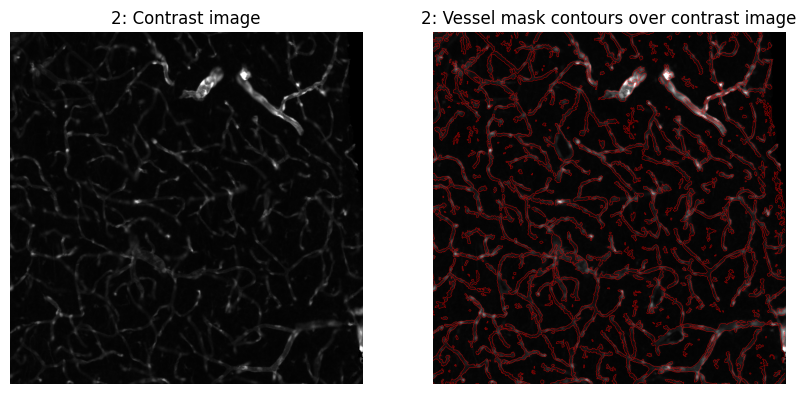

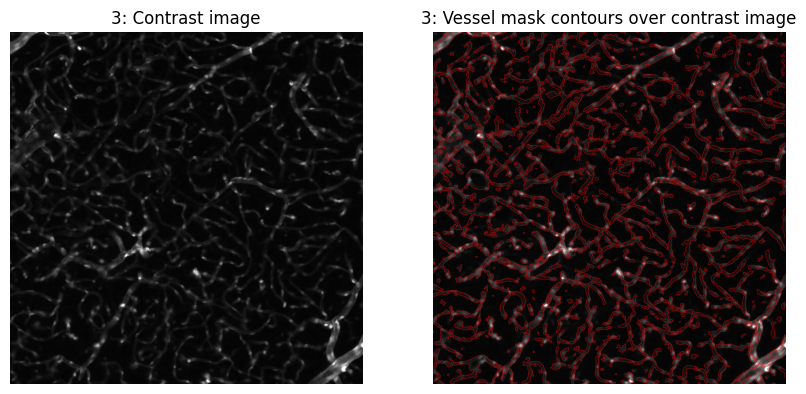

In [16]:
# Parameters for vessel detection
sigma_minimum = 1.0  # Range of scales in which MultiScaleHessianBasedMeasureImageFilter will search for vessels
sigma_maximum = 10.0  # 10
number_of_sigma_steps = 10  # 10 Number of scales to search for vessels

# Parameters for post-processing
thresh = 230  # Threshold for binarization, 230
min_size = 10  # Minimum size of objects to keep
area_threshold = 2000 # Minimum area of holes to keep
smoothing = 1  # Smoothing factor for closing, 3

xlim = [4000, 5000]  # 8000, 9000 or 9000, 10000
ylim = [4000, 5000]  # 8000, 9000

#############################################################

# Alternative: load image in memory
input_image = contrast_ch1 * bg_mask
input_image = input_image.astype(np.float32)
#input_image *= 255.0

# Print statistics
print("Input image type:", input_image.dtype)
print("Input image min:", input_image.min())
print("Input image max:", input_image.max())

# Run the vessel detection
segmented_vessels_array = detect_vessels(input_image, sigma_minimum, sigma_maximum, number_of_sigma_steps)

# Process the thresholded vessels
thresholded_vessels_ch1 = process_vessels(segmented_vessels_array, thresh=thresh, min_size=min_size, area_threshold=area_threshold, smoothing=smoothing)
thresholded_vessels_ch1 = thresholded_vessels_ch1 * bg_mask

# Print statistics
print("Vesselness image statistics:")
print("Shape:", segmented_vessels_array.shape)
print("Min:", segmented_vessels_array.min())
print("Max:", segmented_vessels_array.max())
print("Mean:", segmented_vessels_array.mean())
print("Median:", np.median(segmented_vessels_array))
#print("Std:", segmented_vessels_array.std())

# Plot the raw vesselness image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(segmented_vessels_array, cmap='gray')
plt.axis('off')
plt.title("Vesselness image")
plt.subplot(1, 2, 2)
plt.imshow(thresholded_vessels_ch1, cmap='gray')
plt.axis('off')
plt.title("Vessel mask")
plt.show()

# Show the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.axis('off')
plt.title("Contrast image")
plt.subplot(1, 2, 2)
plt.imshow(input_image, cmap='gray')
plt.contour(thresholded_vessels_ch1, colors='red', linewidths=0.5, alpha=0.45)
plt.axis('off')
plt.title("Vessel mask contours over contrast image")
plt.show()

# Plot the raw vesselness image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(segmented_vessels_array, cmap='gray')
plt.axis('off')
plt.title("Vesselness image")
plt.xlim(xlim)
plt.ylim(ylim)
plt.subplot(1, 2, 2)
plt.imshow(thresholded_vessels_ch1, cmap='gray')
plt.axis('off')
plt.title("Vessel mask")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# Show the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.axis('off')
plt.title("Contrast image")
plt.xlim(xlim)
plt.ylim(ylim)
plt.subplot(1, 2, 2)
plt.imshow(input_image, cmap='gray')
plt.contour(thresholded_vessels_ch1, colors='red', linewidths=0.5, alpha=0.45)
plt.axis('off')
plt.title("Vessel mask contours over contrast image")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# Show the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.axis('off')
plt.title("2: Contrast image")
plt.xlim(ylim)
plt.ylim(ylim)
plt.subplot(1, 2, 2)
plt.imshow(input_image, cmap='gray')
plt.contour(thresholded_vessels_ch1, colors='red', linewidths=0.5, alpha=0.45)
plt.axis('off')
plt.title("2: Vessel mask contours over contrast image")
plt.xlim(ylim)
plt.ylim(ylim)
plt.show()

# Show the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.axis('off')
plt.title("3: Contrast image")
plt.xlim([2000, 3000])
plt.ylim([2000, 3000])
plt.subplot(1, 2, 2)
plt.imshow(input_image, cmap='gray')
plt.contour(thresholded_vessels_ch1, colors='red', linewidths=0.5, alpha=0.45)
plt.axis('off')
plt.title("3: Vessel mask contours over contrast image")
plt.xlim([2000, 3000])
plt.ylim([2000, 3000])
plt.show()

Input image type: float32
Input image min: 0.0
Input image max: 65535.0
Vesselness image statistics:
Shape: (9166, 11914)
Min: 0.0
Max: 255.0
Mean: 137.15225
Median: 241.0


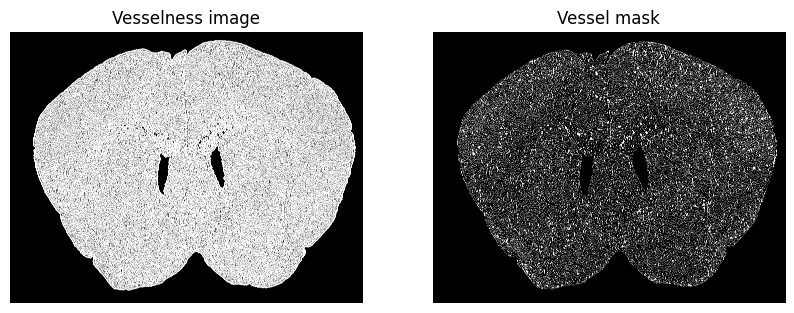

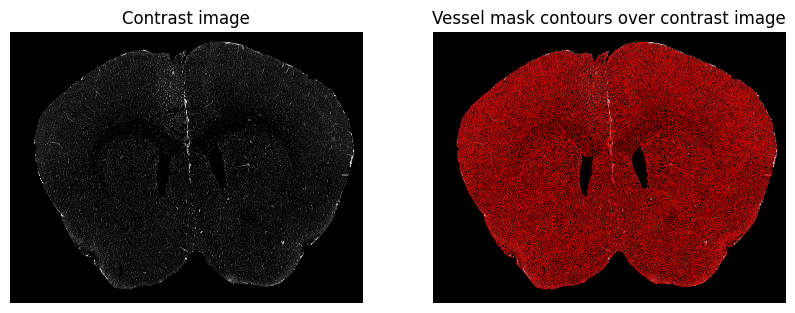

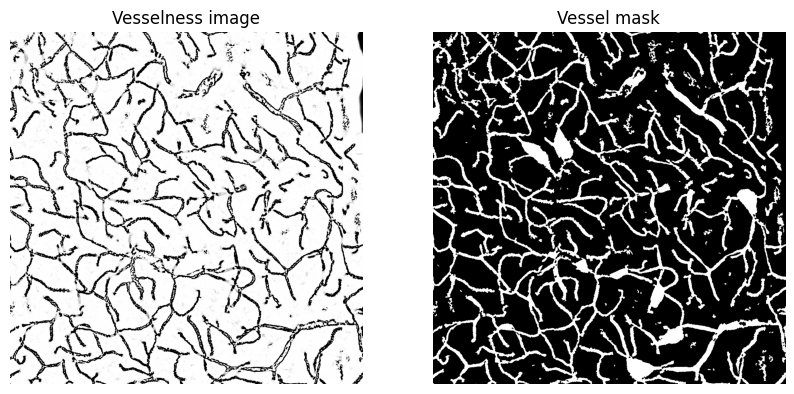

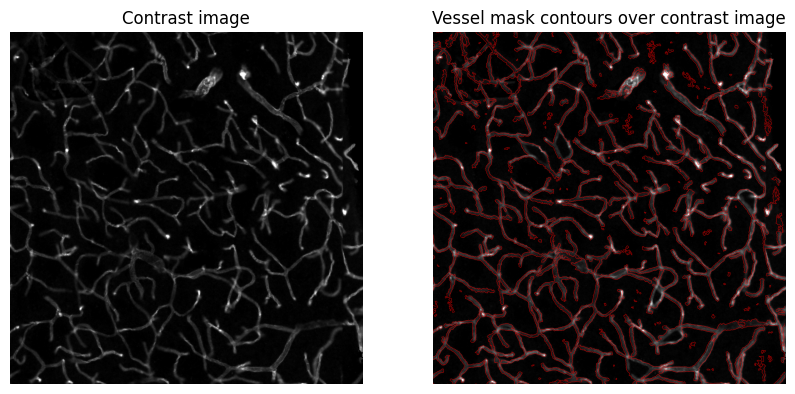

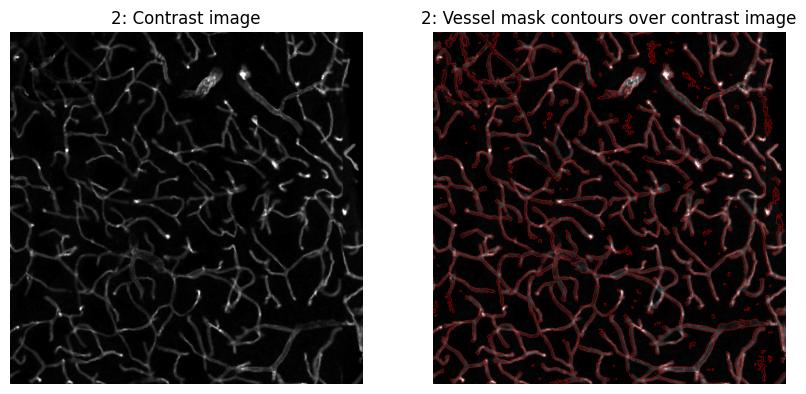

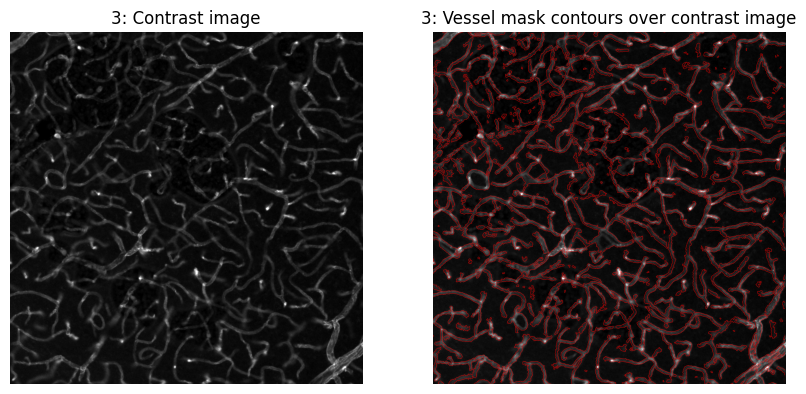

In [17]:
# Parameters for vessel detection
sigma_minimum = 1.0  # Range of scales in which MultiScaleHessianBasedMeasureImageFilter will search for vessels
sigma_maximum = 10.0  # 10
number_of_sigma_steps = 10  # 10 Number of scales to search for vessels

# Parameters for post-processing
thresh = 230  # Threshold for binarization, 230
min_size = 10  # Minimum size of objects to keep
area_threshold = 2000 # Minimum area of holes to keep
smoothing = 1  # Smoothing factor for closing, 3

xlim = [4000, 5000]  # 8000, 9000 or 9000, 10000
ylim = [4000, 5000]  # 8000, 9000

#############################################################

# Alternative: load image in memory
input_image = contrast_ch2 * bg_mask
input_image = input_image.astype(np.float32)
#input_image *= 255.0

# Print statistics
print("Input image type:", input_image.dtype)
print("Input image min:", input_image.min())
print("Input image max:", input_image.max())

# Run the vessel detection
segmented_vessels_array = detect_vessels(input_image, sigma_minimum, sigma_maximum, number_of_sigma_steps)

# Process the thresholded vessels
thresholded_vessels_ch2 = process_vessels(segmented_vessels_array, thresh=thresh, min_size=min_size, area_threshold=area_threshold, smoothing=smoothing)
thresholded_vessels_ch2 = thresholded_vessels_ch2 * bg_mask

# Print statistics
print("Vesselness image statistics:")
print("Shape:", segmented_vessels_array.shape)
print("Min:", segmented_vessels_array.min())
print("Max:", segmented_vessels_array.max())
print("Mean:", segmented_vessels_array.mean())
print("Median:", np.median(segmented_vessels_array))
#print("Std:", segmented_vessels_array.std())

# Plot the raw vesselness image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(segmented_vessels_array, cmap='gray')
plt.axis('off')
plt.title("Vesselness image")
plt.subplot(1, 2, 2)
plt.imshow(thresholded_vessels_ch2, cmap='gray')
plt.axis('off')
plt.title("Vessel mask")
plt.show()

# Show the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.axis('off')
plt.title("Contrast image")
plt.subplot(1, 2, 2)
plt.imshow(input_image, cmap='gray')
plt.contour(thresholded_vessels_ch2, colors='red', linewidths=0.5, alpha=0.45)
plt.axis('off')
plt.title("Vessel mask contours over contrast image")
plt.show()

# Plot the raw vesselness image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(segmented_vessels_array, cmap='gray')
plt.axis('off')
plt.title("Vesselness image")
plt.xlim(xlim)
plt.ylim(ylim)
plt.subplot(1, 2, 2)
plt.imshow(thresholded_vessels_ch2, cmap='gray')
plt.axis('off')
plt.title("Vessel mask")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# Show the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.axis('off')
plt.title("Contrast image")
plt.xlim(xlim)
plt.ylim(ylim)
plt.subplot(1, 2, 2)
plt.imshow(input_image, cmap='gray')
plt.contour(thresholded_vessels_ch2, colors='red', linewidths=0.5, alpha=0.45)
plt.axis('off')
plt.title("Vessel mask contours over contrast image")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# Show the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.axis('off')
plt.title("2: Contrast image")
plt.xlim(ylim)
plt.ylim(ylim)
plt.subplot(1, 2, 2)
plt.imshow(input_image, cmap='gray')
plt.contour(thresholded_vessels_ch2, colors='red', linewidths=0.5, alpha=0.45)
plt.axis('off')
plt.title("2: Vessel mask contours over contrast image")
plt.xlim(ylim)
plt.ylim(ylim)
plt.show()

# Show the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.axis('off')
plt.title("3: Contrast image")
plt.xlim([2000, 3000])
plt.ylim([2000, 3000])
plt.subplot(1, 2, 2)
plt.imshow(input_image, cmap='gray')
plt.contour(thresholded_vessels_ch2, colors='red', linewidths=0.5, alpha=0.45)
plt.axis('off')
plt.title("3: Vessel mask contours over contrast image")
plt.xlim([2000, 3000])
plt.ylim([2000, 3000])
plt.show()

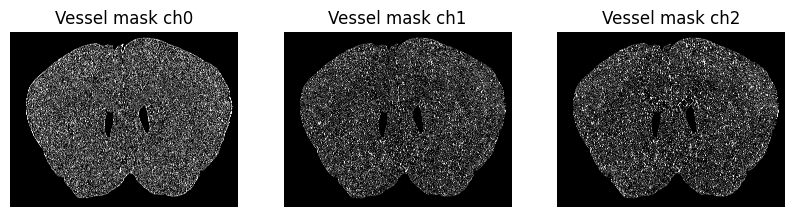

In [18]:
# Compare side-by-side
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(thresholded_vessels_ch0, cmap='gray')
plt.axis('off')
plt.title("Vessel mask ch0")
plt.subplot(1, 3, 2)
plt.imshow(thresholded_vessels_ch1, cmap='gray')
plt.axis('off')
plt.title("Vessel mask ch1")
plt.subplot(1, 3, 3)
plt.imshow(thresholded_vessels_ch2, cmap='gray')
plt.axis('off')
plt.title("Vessel mask ch2")
plt.show()

np.save("mask_enhanced_ch0.npy", thresholded_vessels_ch0)
np.save("mask_enhanced_ch1.npy", thresholded_vessels_ch1)
np.save("mask_enhanced_ch2.npy", thresholded_vessels_ch2)

## Compute statistics 

In [5]:
import csv
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from scipy.spatial.distance import hamming

def dice_coefficient(binary_image1, binary_image2, epsilon=1e-10):
    """
    Compute the Dice coefficient between two binary images.
    
    Parameters:
    - binary_image1: First binary image (numpy array).
    - binary_image2: Second binary image (numpy array).
    
    Returns:
    - dice: Dice coefficient.
    """
    intersection = np.sum(binary_image1 * binary_image2)
    size1 = np.sum(binary_image1)
    size2 = np.sum(binary_image2)
    
    dice = (2. * intersection + epsilon) / (size1 + size2 + epsilon)
    return dice


def iou(binary_image1, binary_image2, epsilon=1e-10):
    """
    Compute the Intersection over Union (IoU) between two binary images.
    
    Parameters:
    - binary_image1: First binary image (numpy array).
    - binary_image2: Second binary image (numpy array).
    
    Returns:
    - iou: IoU.
    """
    intersection = np.sum(binary_image1 * binary_image2)
    union = np.sum(binary_image1 + binary_image2)
    
    if union == 0:
        iou = 1.0
    
    iou = (intersection + epsilon) / (union + epsilon)
    return iou


def precision(binary_image1, binary_image2, epsilon=1e-10):
    """
    Compute the precision between two binary images.
    
    Parameters:
    - binary_image1: First binary image (numpy array).
    - binary_image2: Second binary image (numpy array).
    
    Returns:
    - precision: Precision.
    """
    true_positives = np.sum(binary_image1 * binary_image2)
    false_positives = np.sum(binary_image1 * (1 - binary_image2))
    
    precision = (true_positives) / (true_positives + false_positives + epsilon)
    return precision


def recall(binary_image1, binary_image2, epsilon=1e-10):
    """
    Compute the recall between two binary images.
    
    Parameters:
    - binary_image1: First binary image (numpy array).
    - binary_image2: Second binary image (numpy array).
    
    Returns:
    - recall: Recall.
    """
    true_positives = np.sum(binary_image1 * binary_image2)
    false_negatives = np.sum((1 - binary_image1) * binary_image2)
    
    recall = true_positives / (true_positives + false_negatives + epsilon)
    return recall


def rand_index(binary_image1, binary_image2):
    """
    Compute the Rand index between two binary images.
    
    Parameters:
    - binary_image1: First binary image (numpy array).
    - binary_image2: Second binary image (numpy array).
    
    Returns:
    - rand_index: Rand index.
    """
    true_positives = np.sum(binary_image1 * binary_image2)
    false_positives = np.sum(binary_image1 * (1 - binary_image2))
    false_negatives = np.sum((1 - binary_image1) * binary_image2)
    true_negatives = np.sum((1 - binary_image1) * (1 - binary_image2))
    
    rand_index = (true_positives + true_negatives) / (true_positives + false_positives + false_negatives + true_negatives)
    return rand_index


In [20]:
thresholded_ch0 = thresholded_vessels_ch0
thresholded_ch1 = thresholded_vessels_ch1
thresholded_ch2 = thresholded_vessels_ch2

# Compute the metrics
dice_score = dice_coefficient(thresholded_ch0, thresholded_ch1)  
iou_score = iou(thresholded_ch0, thresholded_ch1)  # Strongly penalizes over-segmentation and under-segmentation
precision_score = precision(thresholded_ch0, thresholded_ch1) 
recall_score = recall(thresholded_ch0, thresholded_ch1)
ssim_score = ssim(thresholded_ch0, thresholded_ch1)
mse_score = mean_squared_error(thresholded_ch0, thresholded_ch1)
thresh_ch0_flat = thresholded_ch0.flatten()
thresh_ch1_flat = thresholded_ch1.flatten()
hamming_distance = hamming(thresh_ch0_flat, thresh_ch1_flat)
rand_score = rand_index(thresholded_ch0, thresholded_ch1)  # Measures how close points are clustered together

print("Dice coefficient:", dice_score)
print("IoU score:", iou_score)
print("Precision score:", precision_score)
print("Recall score:", recall_score)
print("SSIM score:", ssim_score)
print("MSE score:", mse_score)
print("Hamming distance:", hamming_distance)
print("Rand index:", rand_score)

# Write the solutions to a CSV file
csv_filename = 'stats_enhanced.csv'

# Write to rows
rows = [["Index", "Dice coefficient", "IoU score", "Precision", "Recall", "SSIM", "MSE", "Hamming distance", "Rand index"]]
rows.append([IDX, dice_score, iou_score, precision_score, recall_score, ssim_score, mse_score, hamming_distance, rand_score])

with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

Dice coefficient: 0.29747145156572974
IoU score: 0.17472332657170375
Precision score: 0.25741125528726616
Recall score: 0.3522987194488827
SSIM score: 0.515975033047741
MSE score: 0.23168029507858176
Hamming distance: 0.23168029507858176
Rand index: 0.7683197049214182


Run the whole thing

In [6]:
from tqdm import tqdm

data_path = "/media/data/u01/Endothelial_enhancer/Fig3_M14_*.tif"
output_ch0_path = "/media/data/u01/lightsheet/quant2/M14/segmentation/ch0/"
output_ch1_path = "/media/data/u01/lightsheet/quant2/M14/segmentation/ch1/"
output_ch2_path = "/media/data/u01/lightsheet/quant2/M14/segmentation/ch2/"
output_csv_ch0_ch1_path = "/media/data/u01/lightsheet/quant2/M14/segmentation/stats_enhanced2_ch0_ch1.csv"
output_csv_ch0_ch2_path = "/media/data/u01/lightsheet/quant2/M14/segmentation/stats_enhanced2_ch0_ch2.csv"
output_csv_ch1_ch2_path = "/media/data/u01/lightsheet/quant2/M14/segmentation/stats_enhanced2_ch1_ch2.csv"

################################################################################

gamma_ch0 = 2  # You can adjust this value to control the contrast enhancement
contrast_alpha_ch0 = 0.5  # Try 0.15 You can adjust this value to control the brightness enhancement 0.5 default
gamma_ch1 = 2
contrast_alpha_ch1 = 1.5
gamma_ch2 = 2
contrast_alpha_ch2 = 1.5

# Parameters for vessel detection
sigma_minimum = 1.0  # Range of scales in which MultiScaleHessianBasedMeasureImageFilter will search for vessels
sigma_maximum = 10.0  # 10
number_of_sigma_steps = 10  # 10 Number of scales to search for vessels

# Parameters for post-processing
thresh = 230  # Threshold for binarization, 230
min_size = 500  # Minimum size of objects to keep
area_threshold = 2000 # Minimum area of holes to keep
smoothing = 1  # Smoothing factor for closing, 3

# Read all tif files in the folder
data_files = sorted(glob.glob(data_path))
rows_ch0_ch1 = [["Index", "Dice coefficient", "IoU score", "Precision", "Recall", "SSIM", "MSE", "Hamming distance", "Rand index"]]
rows_ch0_ch2 = [["Index", "Dice coefficient", "IoU score", "Precision", "Recall", "SSIM", "MSE", "Hamming distance", "Rand index"]]
rows_ch1_ch2 = [["Index", "Dice coefficient", "IoU score", "Precision", "Recall", "SSIM", "MSE", "Hamming distance", "Rand index"]]

for i in tqdm(range(len(data_files))):
    curr_img = read_tif(data_files[i])
    curr_ch0 = curr_img[0]
    curr_ch1 = curr_img[1]
    curr_ch2 = curr_img[2]
    
    # Compute the original image contrast
    contrast_ch0 = curr_ch0
    contrast_ch1 = curr_ch1
    contrast_ch2 = curr_ch2
    
    #contrast_ch0 = gamma_correction(curr_ch0, gamma=gamma_ch0)
    #contrast_ch0 = auto_contrast(contrast_ch0, alpha=contrast_alpha_ch0)
    #contrast_ch1 = gamma_correction(curr_ch1, gamma=gamma_ch1)
    #contrast_ch1 = auto_contrast(contrast_ch1, alpha=contrast_alpha_ch1)
    #contrast_ch2 = gamma_correction(curr_ch2, gamma=gamma_ch2)
    #contrast_ch2 = auto_contrast(contrast_ch2, alpha=contrast_alpha_ch2)
    
    bg_mask = gamma_correction(curr_ch0, gamma=gamma_ch0)
    bg_mask = auto_contrast(bg_mask, alpha=3.0)
    bg_mask = get_brain_mask(bg_mask, area_threshold=100000)
    
    #############################################################

    # Load image in memory
    input_ch0 = contrast_ch0 * bg_mask
    input_ch0 = input_ch0.astype(np.float32)
    #input_ch0 *= 255.0
    
    input_ch1 = contrast_ch1 * bg_mask
    input_ch1 = input_ch1.astype(np.float32)
    
    input_ch2 = contrast_ch2 * bg_mask
    input_ch2 = input_ch2.astype(np.float32)
    #input_ch1 *= 255.0

    # Run the vessel detection
    segmented_vessels_ch0 = detect_vessels(input_ch0, sigma_minimum, sigma_maximum, number_of_sigma_steps)
    segmented_vessels_ch1 = detect_vessels(input_ch1, sigma_minimum, sigma_maximum, number_of_sigma_steps)
    segmented_vessels_ch2 = detect_vessels(input_ch2, sigma_minimum, sigma_maximum, number_of_sigma_steps)

    # Process the thresholded vessels
    thresholded_vessels_ch0 = process_vessels(segmented_vessels_ch0, thresh=thresh, min_size=min_size, area_threshold=area_threshold, smoothing=smoothing)
    thresholded_vessels_ch1 = process_vessels(segmented_vessels_ch1, thresh=thresh, min_size=min_size, area_threshold=area_threshold, smoothing=smoothing)
    thresholded_vessels_ch2 = process_vessels(segmented_vessels_ch2, thresh=thresh, min_size=min_size, area_threshold=area_threshold, smoothing=smoothing)

    thresholded_vessels_ch0 = thresholded_vessels_ch0 * bg_mask
    thresholded_vessels_ch1 = thresholded_vessels_ch1 * bg_mask
    thresholded_vessels_ch2 = thresholded_vessels_ch2 * bg_mask

    # Save to file
    sitk_ch0 = sitk.GetImageFromArray(thresholded_vessels_ch0.astype(np.uint8))  # Ch0
    output_ch0_file = output_ch0_path + f"ch0_seg_{str(i).zfill(4)}.tif"
    sitk.WriteImage(sitk_ch0, output_ch0_file)
    sitk_ch1 = sitk.GetImageFromArray(thresholded_vessels_ch1.astype(np.uint8))  # Ch1
    output_ch1_file = output_ch1_path + f"ch1_seg_{str(i).zfill(4)}.tif"
    sitk.WriteImage(sitk_ch1, output_ch1_file)
    sitk_ch2 = sitk.GetImageFromArray(thresholded_vessels_ch2.astype(np.uint8))  # Ch1
    output_ch2_file = output_ch2_path + f"ch2_seg_{str(i).zfill(4)}.tif"
    sitk.WriteImage(sitk_ch1, output_ch2_file)
    
    # Compute statistics between ch0 and ch1
    dice_score = dice_coefficient(thresholded_vessels_ch0, thresholded_vessels_ch1)  
    iou_score = iou(thresholded_vessels_ch0, thresholded_vessels_ch1)  # Strongly penalizes over-segmentation and under-segmentation
    precision_score = precision(thresholded_vessels_ch0, thresholded_vessels_ch1) 
    recall_score = recall(thresholded_vessels_ch0, thresholded_vessels_ch1)
    ssim_score = ssim(thresholded_vessels_ch0, thresholded_vessels_ch1)
    mse_score = mean_squared_error(thresholded_vessels_ch0, thresholded_vessels_ch1)
    thresh_ch0_flat = thresholded_vessels_ch0.flatten()
    thresh_ch1_flat = thresholded_vessels_ch1.flatten()
    hamming_distance = hamming(thresh_ch0_flat, thresh_ch1_flat)
    rand_score = rand_index(thresholded_vessels_ch0, thresholded_vessels_ch1)  # Measures how close points are clustered together
    rows_ch0_ch1.append([i, dice_score, iou_score, precision_score, recall_score, ssim_score, mse_score, hamming_distance, rand_score])
    print(rows_ch0_ch1[i + 1])
    
    # Compute statistics between ch0 and ch2
    dice_score = dice_coefficient(thresholded_vessels_ch0, thresholded_vessels_ch2)  
    iou_score = iou(thresholded_vessels_ch0, thresholded_vessels_ch2)  # Strongly penalizes over-segmentation and under-segmentation
    precision_score = precision(thresholded_vessels_ch0, thresholded_vessels_ch2) 
    recall_score = recall(thresholded_vessels_ch0, thresholded_vessels_ch2)
    ssim_score = ssim(thresholded_vessels_ch0, thresholded_vessels_ch2)
    mse_score = mean_squared_error(thresholded_vessels_ch0, thresholded_vessels_ch2)
    thresh_ch2_flat = thresholded_vessels_ch2.flatten()
    hamming_distance = hamming(thresh_ch0_flat, thresh_ch2_flat)
    rand_score = rand_index(thresholded_vessels_ch0, thresholded_vessels_ch2)  # Measures how close points are clustered together
    rows_ch0_ch2.append([i, dice_score, iou_score, precision_score, recall_score, ssim_score, mse_score, hamming_distance, rand_score])
    print(rows_ch0_ch2[i + 1])
    
    # Compute statistics between ch1 and ch2
    dice_score = dice_coefficient(thresholded_vessels_ch1, thresholded_vessels_ch2)  
    iou_score = iou(thresholded_vessels_ch1, thresholded_vessels_ch2)  # Strongly penalizes over-segmentation and under-segmentation
    precision_score = precision(thresholded_vessels_ch1, thresholded_vessels_ch2) 
    recall_score = recall(thresholded_vessels_ch1, thresholded_vessels_ch2)
    ssim_score = ssim(thresholded_vessels_ch1, thresholded_vessels_ch2)
    mse_score = mean_squared_error(thresholded_vessels_ch1, thresholded_vessels_ch2)
    hamming_distance = hamming(thresh_ch1_flat, thresh_ch2_flat)
    rand_score = rand_index(thresholded_vessels_ch1, thresholded_vessels_ch2)  # Measures how close points are clustered together
    rows_ch1_ch2.append([i, dice_score, iou_score, precision_score, recall_score, ssim_score, mse_score, hamming_distance, rand_score])
    print(rows_ch1_ch2[i + 1])
    
with open(output_csv_ch0_ch1_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows_ch0_ch1)
    
with open(output_csv_ch0_ch2_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows_ch0_ch2)
    
with open(output_csv_ch1_ch2_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows_ch1_ch2)

  0%|          | 0/5 [00:00<?, ?it/s]

TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


[0, 0.39998164575963124, 0.2499856609142013, 0.3094150229144146, 0.5655071275317965, 0.47702381538918565, 0.30821885707853697, 0.30821885707853697, 0.691781142921463]
[0, 0.39847644281569317, 0.24881085328290029, 0.30614752792817096, 0.5705423684627672, 0.4823345613039907, 0.3068838842895138, 0.3068838842895138, 0.6931161157104863]


 20%|██        | 1/5 [03:54<15:36, 234.10s/it]

[0, 0.7806867946731599, 0.6402676451485612, 0.773156135883527, 0.7883655959254005, 0.7715726157223002, 0.07891359089548998, 0.07891359089548998, 0.92108640910451]


TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


[1, 0.4073888223391731, 0.2557992986948214, 0.3196518063810578, 0.5615104268368651, 0.5223912020067375, 0.2801358914701346, 0.2801358914701346, 0.7198641085298654]
[1, 0.4025864697741432, 0.25202395131661487, 0.31097372629711584, 0.5707205221866904, 0.5274592359098993, 0.2780164151871086, 0.2780164151871086, 0.7219835848128914]


 40%|████      | 2/5 [08:50<13:32, 270.69s/it]

[1, 0.7570173984761236, 0.6090329804681358, 0.7407990238365997, 0.7739618087232488, 0.7676575936615716, 0.08154923998526659, 0.08154923998526659, 0.9184507600147335]


TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


[2, 0.40248472143114283, 0.25194420787744265, 0.31231608343773226, 0.5658514397475116, 0.5161521228826076, 0.280847157299969, 0.280847157299969, 0.719152842700031]
[2, 0.3978945320971768, 0.2483572649046794, 0.30523388234177096, 0.5713367168429362, 0.5207431797659589, 0.27977790090594357, 0.27977790090594357, 0.7202220990940564]


 60%|██████    | 3/5 [14:42<10:16, 308.03s/it]

[2, 0.7344190005888007, 0.5803018541922507, 0.7226464635783669, 0.7465814594193557, 0.7594364654826165, 0.08736690875900081, 0.08736690875900081, 0.9126330912409992]


TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


[3, 0.42627378103551955, 0.27086908504073204, 0.3497342067515601, 0.5457007750220935, 0.755537037475571, 0.1380082173578785, 0.1380082173578785, 0.8619917826421215]
[3, 0.4276354502552407, 0.2719696588966334, 0.34976416606569155, 0.550112072101933, 0.7574456689122326, 0.13725402792643487, 0.13725402792643487, 0.8627459720735651]


 80%|████████  | 4/5 [20:23<05:20, 320.73s/it]

[3, 0.7793262204375814, 0.6384393877264658, 0.776234660603904, 0.7824425046520253, 0.8821073187755203, 0.04130082962000423, 0.04130082962000423, 0.9586991703799957]


TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


[4, 0.42909772272179414, 0.27315367030039717, 0.33216931905991787, 0.6059026684430527, 0.5782672417741926, 0.24819300625265092, 0.24819300625265092, 0.751806993747349]
[4, 0.4290954791281577, 0.27315185195979474, 0.33239913599551874, 0.6051305747775269, 0.5794242868988765, 0.2483669974324333, 0.2483669974324333, 0.7516330025675667]


100%|██████████| 5/5 [24:45<00:00, 297.08s/it]

[4, 0.7727807817767773, 0.6297006845244937, 0.7735414538946107, 0.7720216042230201, 0.8018419285391242, 0.07002505348103323, 0.07002505348103323, 0.9299749465189667]
